# Segmentation using a neural network

In [1]:
import os 
import sys
import random
import warnings
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import load_model
import numpy as np
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
TEST_PATH = 'all/stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]
len(test_ids)

65

In [5]:
# metric to measure model performance
# also needed when loading the modle
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# the mythical u-net
model = load_model('dsb.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X_test[n] = img
    
X_test.shape

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 190.15it/s]


(65, 128, 128, 3)

In [13]:
# test images
X_test.shape

(65, 128, 128, 3)

In [14]:
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 4s 59ms/step


In [15]:
preds_test.shape

(65, 128, 128, 1)

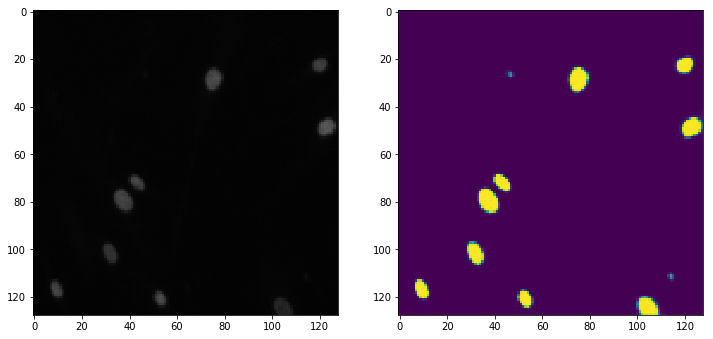

In [29]:
idx = random.randint(0, len(preds_test))

fig=plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)

ax1.imshow(np.squeeze(X_test[idx]))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.squeeze(preds_test[idx]))

# Predict on one image
* Needed while inferencing

In [30]:
X_test.shape

(65, 128, 128, 3)

In [31]:
img = X_test[random.randint(0, len(preds_test))]

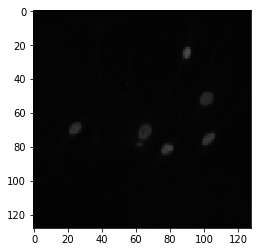

In [32]:
plt.imshow(img)

In [33]:
img.shape

(128, 128, 3)

In [34]:
img_4d = np.expand_dims(img, axis=0) # rank 4 tensor for keras prediction
img_4d.shape

(1, 128, 128, 3)

In [35]:
pred = model.predict(img_4d, verbose=1)
pred.shape

1/1 [==============================] - 0s 79ms/step


(1, 128, 128, 1)

In [36]:
pred = np.squeeze(pred)
pred.shape

(128, 128)

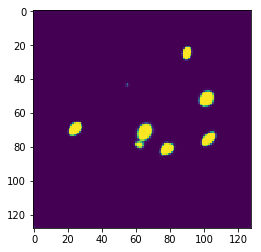

In [37]:
plt.imshow(pred)

In [136]:
x = np.array([[[0], [1], [2]]])
x.shape

(1, 3, 1)

In [137]:
print(np.squeeze(x).shape)
print(np.squeeze(x, axis=0).shape)


(3,)
(3, 1)


In [47]:
'''
Takes image as an input
    - Changes dimension to prop format
    - Make pred
    - Change dim to get predicted image info
'''

def segment(img):
    img_4d = np.expand_dims(img, axis=0)  # rank 4 tensor for prediction
    pred = model.predict(img_4d, verbose=1)
    pred = np.squeeze(pred) # change dim to get 3-channel image
    return pred

1/1 [==============================] - 0s 87ms/step


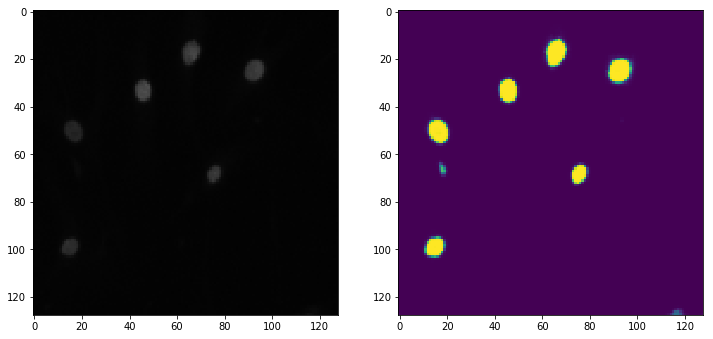

In [41]:
idx = random.randint(0, len(preds_test))

img = X_test[idx]
segmented_img = segment(img)

fig=plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)

ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(segmented_img)

# Run a prediction on random sample image

In [42]:
img = cv2.imread("test1.jpg") # test1, test2
img.shape

(301, 450, 3)

(128, 128, 3)


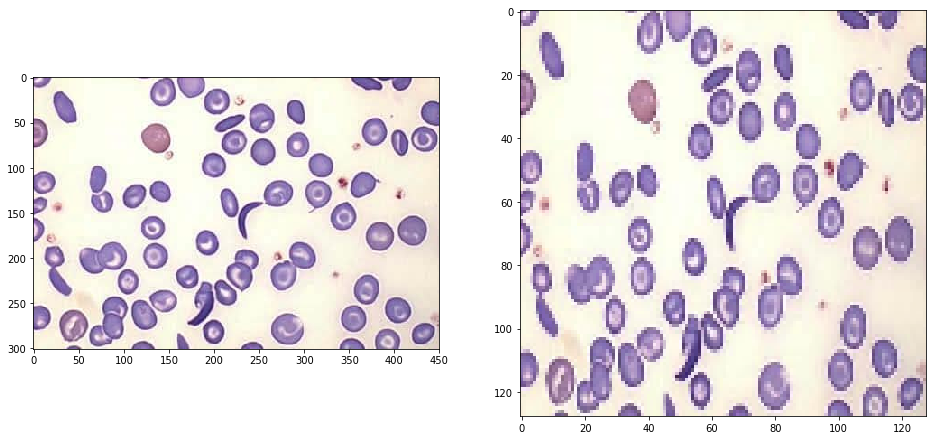

In [43]:
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cv2.IMREAD_GRAYSCALE
img_rs = cv2.resize(img, (128, 128))
print(img_rs.shape)

fig=plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_rs, cmap='binary')

In [44]:
print("Prev shape: {}" .format(img_rs.shape))

# use if image is grayscale
def to_rgb(img):
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb
#img_rs = to_rgb(img_rs)

Prev shape: (128, 128, 3)


In [45]:
sg = segment(img_rs)
sg.shape

1/1 [==============================] - 0s 83ms/step


(128, 128)

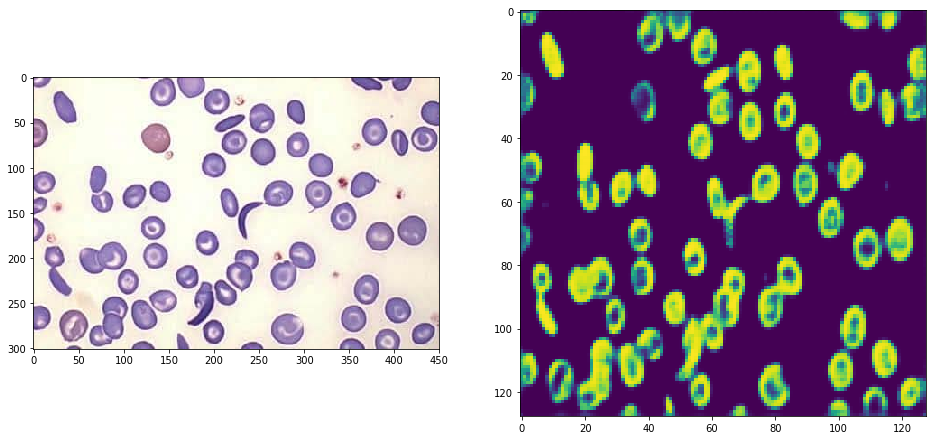

In [46]:
fig=plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sg)